##  Libraries

In [2]:
# Load PyTorch and Essential Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sys

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import pathlib
from tqdm import tqdm

# Geospatial data
import rioxarray as rxr
import rasterio

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

# File operations
import requests
import pyunpack
from rarfile import RarFile

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory: 8.00 GB


## Trainning Loop

In [3]:
# Training Functions

def compute_metrics(pred, target):
    """
    Compute accuracy and MSE metrics.
    Matches TensorFlow metrics=['accuracy', 'mse'].
    
    Args:
        pred: predicted masks (B, 1, H, W)
        target: ground truth masks (B, 1, H, W)
    
    Returns:
        accuracy, mse
    """

    # 1. Convert Logits to Probabilities for Metrics
    probs = torch.sigmoid(pred)

    pred_binary = (probs > 0.5).float()
    
    # Accuracy: percentage of correct pixels
    accuracy = (pred_binary == target).float().mean().item()
    
    # MSE: mean squared error
    mse = F.mse_loss(probs, target).item()
    
    return accuracy, mse

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=30, steps_per_epoch=100, device='cuda',
                save_path='model.pth', verbose=1):
    """
    Training loop matching TensorFlow model.fit().
    
    Args:
        model: PyTorch model
        train_loader: training DataLoader
        val_loader: validation DataLoader
        criterion: loss function
        optimizer: optimizer
        num_epochs: number of epochs
        steps_per_epoch: iterations per epoch (matches TF)
        device: 'cuda' or 'cpu'
        save_path: path to save best model
        verbose: print frequency (0=silent, 1=progress bar, 2=one line per epoch)
    
    Returns:
        history: dict with training metrics
    """
    model.to(device)
    best_val_acc = 0.0
    
    history = {
        'loss': [],
        'accuracy': [],
        'mse': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_mse': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_mse = 0.0
        
        # Create iterator and control steps per epoch
        train_iter = iter(train_loader)
        
        # Progress bar for training
        if verbose == 1:
            pbar = tqdm(range(steps_per_epoch), desc=f'Epoch {epoch+1}/{num_epochs}')
        else:
            pbar = range(steps_per_epoch)
        
        for step in pbar:
            try:
                images, masks = next(train_iter)
            except StopIteration:
                # Reset iterator when exhausted
                train_iter = iter(train_loader)
                images, masks = next(train_iter)
            
            images = images.to(device)
            #masks = masks.to(device)
            masks = masks.to(device).float()

            if len(masks.shape) == 3:#
                masks = masks.unsqueeze(1)#
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            acc, mse = compute_metrics(outputs, masks)
            
            train_loss += loss.item()
            train_acc += acc
            train_mse += mse
            
            # Update progress bar
            if verbose == 1:
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{acc:.4f}'
                })
        
        # Average training metrics
        train_loss /= steps_per_epoch
        train_acc /= steps_per_epoch
        train_mse /= steps_per_epoch
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_mse = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device).float()

                if len(masks.shape) == 3:#
                    masks = masks.unsqueeze(1)#
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                acc, mse = compute_metrics(outputs, masks)
                
                val_loss += loss.item()
                val_acc += acc
                val_mse += mse
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_mse /= len(val_loader)
        
        # Save best model (matching ModelCheckpoint behavior)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, save_path)
            if verbose >= 1:
                print(f"\nEpoch {epoch+1}: val_accuracy improved to {val_acc:.4f}, saving model to {save_path}")
        
        # Store history
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['mse'].append(train_mse)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_mse'].append(val_mse)
        
        # Print epoch summary
        if verbose == 2 or (verbose == 1 and epoch % 5 == 0):
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - mse: {train_mse:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - val_mse: {val_mse:.4f}")
    
    return history

def plot_training_history(history, save_path=None):
    """
    Plot training history matching TensorFlow style.
    
    Args:
        history: dict with keys ['loss', 'accuracy', 'val_loss', 'val_accuracy']
        save_path: optional path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    axes[0].plot(history['accuracy'], label='Training')
    axes[0].plot(history['val_accuracy'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history['loss'], label='Training')
    axes[1].plot(history['val_loss'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend(loc='upper left')
    axes[1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

## Model arquitecture 

In [4]:
# Model 2: Attention U-Net (PRIMARY MODEL)

class AttentionBlock(nn.Module):
    """
    Attention Gate for Attention U-Net.
    
    Implements the attention mechanism from:
    "Attention U-Net: Learning Where to Look for the Pancreas"
    
    TensorFlow operations converted:
    - K.int_shape() → tensor.shape
    - tf.broadcast_to() → tensor.expand_as()
    - multiply() → *
    """
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: number of filters in gating signal
            F_l: number of filters in skip connection
            F_int: number of intermediate filters
        """
        super(AttentionBlock, self).__init__()
        
        # Gating signal pathway
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(F_int)
        )
        
        # Skip connection pathway
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(F_int)
        )
        
        # Attention coefficient
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        """
        Args:
            g: gating signal from decoder (coarser scale)
            x: skip connection from encoder (finer scale)
        
        Returns:
            attention-weighted skip connection
        """
        # Process gating signal
        g1 = self.W_g(g)
        
        # Process skip connection with max pooling to match gating size
        # TF: MaxPooling2D((2,2))(theta_x)

        x1 = self.W_x(x)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2)

        # Combine and apply attention
        # TF: add([phi_g, theta_x])
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        # Upsample attention map to match skip connection size
        # TF: UpSampling2D(...) then tf.broadcast_to()
        psi = F.interpolate(psi, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        # Apply attention: multiply with skip connection
        # TF: multiply([upsample_psi, x])
        out = x * psi
        
        return out

class AttentionUNet(nn.Module):
    """
    Attention U-Net architecture.
    Matches TensorFlow UNetAM implementation.
    
    Architecture:
    - Encoder: 4 blocks with progressive filters
    - Bottleneck: Highest filter count
    - Decoder: 4 blocks with attention gates
    - Attention gates applied at each decoder level
    """
    def __init__(self, in_channels=3, out_channels=1, filter_base=16):
        """
        Args:
            in_channels: input channels (3 for RGB, 4 for 4-band)
            out_channels: output channels (1 for binary)
            filter_base: base number of filters (16 in original)
        """
        super(AttentionUNet, self).__init__()
        
        # Calculate filter sizes matching TensorFlow
        # filters = [16, 32, 64, 128, 256]
        filters = [filter_base * (2**i) for i in range(5)]
        
        # Encoder
        self.encoder1 = self._conv_block(in_channels, filters[0])
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.encoder2 = self._conv_block(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.encoder3 = self._conv_block(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.encoder4 = self._conv_block(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = self._conv_block(filters[3], filters[4])
        
        # Attention gates
        self.att4 = AttentionBlock(F_g=filters[4], F_l=filters[3], F_int=filters[3])
        self.att3 = AttentionBlock(F_g=filters[3], F_l=filters[2], F_int=filters[2])
        self.att2 = AttentionBlock(F_g=filters[2], F_l=filters[1], F_int=filters[1])
        self.att1 = AttentionBlock(F_g=filters[1], F_l=filters[0], F_int=filters[0])
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.decoder4 = self._conv_block(filters[4], filters[3])
        
        self.upconv3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.decoder3 = self._conv_block(filters[3], filters[2])
        
        self.upconv2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.decoder2 = self._conv_block(filters[2], filters[1])
        
        self.upconv1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.decoder1 = self._conv_block(filters[1], filters[0])
        
        # Output
        self.conv_out = nn.Conv2d(filters[0], out_channels, kernel_size=1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _conv_block(self, in_channels, out_channels):
        """
        Matches convBlock2 from TensorFlow.
        Two convolutions with ReLU activations.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder with attention gates
        # Level 4
        d4 = self.upconv4(bottleneck)
        enc4_att = self.att4(g=bottleneck, x=enc4)
        d4 = torch.cat([d4, enc4_att], dim=1)
        d4 = self.decoder4(d4)
        
        # Level 3
        d3 = self.upconv3(d4)
        enc3_att = self.att3(g=d4, x=enc3)
        d3 = torch.cat([d3, enc3_att], dim=1)
        d3 = self.decoder3(d3)
        
        # Level 2
        d2 = self.upconv2(d3)
        enc2_att = self.att2(g=d3, x=enc2)
        d2 = torch.cat([d2, enc2_att], dim=1)
        d2 = self.decoder2(d2)
        
        # Level 1
        d1 = self.upconv1(d2)
        enc1_att = self.att1(g=d2, x=enc1)
        d1 = torch.cat([d1, enc1], dim=1)#torch.cat([d1, enc1_att], dim=1)#torch.cat([d1, enc1], dim=1)#torch.cat([d1, enc1_att], dim=1)
        d1 = self.decoder1(d1)
        
        # Output
        out = self.conv_out(d1)#torch.sigmoid(self.conv_out(d1))
        
        return out

## Loading Data

In [5]:
import os
import glob
import numpy as np
import torch
import rasterio
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

# --- CONFIGURATION ---
# Point this to your main folder containing 'images' and 'masks'
base_dir = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/attention-mechanism-unet/chile/Validation" 
BATCH_SIZE = 8 # Increased from 2 for better stability (if GPU allows)

def get_4band_transforms(split="train", img_size=512):
    transforms_list = [
        A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_LINEAR),
    ]
    
    if split == "train":
        transforms_list.extend([
            # Geometric Augmentations (Safe for 4-Band)
            A.Rotate(limit=180, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
            A.ShiftScaleRotate(
                shift_limit=0.25, 
                scale_limit=0.25, 
                rotate_limit=0, 
                border_mode=cv2.BORDER_REFLECT_101, 
                p=0.7
            ),
            A.Affine(shear=(-14, 14), border_mode=cv2.BORDER_REFLECT_101, p=0.5),
            A.HorizontalFlip(p=0.7),
            A.VerticalFlip(p=0.7),
        ])
    
    transforms_list.append(ToTensorV2())
    return A.Compose(transforms_list)

class FourBandAmazonDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # A. Load 4-Band Image
        with rasterio.open(self.image_paths[idx]) as src:
            # Transpose (C, H, W) -> (H, W, C) for Albumentations
            image = src.read().transpose(1, 2, 0).astype(np.float32)

            # Normalization
            img_min = image.min()
            img_max = image.max()
            image = (image - img_min) / (img_max - img_min + 1e-8)

        # B. Load Mask
        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1).astype(np.float32)

        # Match Dimensions (Crop if needed)
        h, w = image.shape[:2]
        mh, mw = mask.shape[:2]
        
        if mh != h or mw != w:
            mask = mask[:h, :w]

        # C. Apply Transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        # D. Final Formatting
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        
        mask = mask.long() # Shape (H, W) for CrossEntropy

        return image, mask

def get_all_filepaths(root_dir):
    """
    Reads all files from root_dir/images and matches them with root_dir/masks
    """
    img_dir = os.path.join(root_dir, "images")
    mask_dir = os.path.join(root_dir, "masks")
    
    # Sort to ensure alignment
    image_files = sorted(glob.glob(os.path.join(img_dir, "*")))
    
    mask_files = []
    valid_imgs = []
    
    for img_path in image_files:
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        
        # Check if corresponding mask exists
        if os.path.exists(mask_path):
            valid_imgs.append(img_path)
            mask_files.append(mask_path)
        else:
            print(f"⚠️ Warning: Mask not found for {filename}, skipping.")
            
    return valid_imgs, mask_files

# --- MAIN EXECUTION ---

# 1. Get ALL Data
print("Scanning files...")
all_imgs, all_masks = get_all_filepaths(base_dir)
print(f"Found {len(all_imgs)} valid image/mask pairs.")

# 2. Perform Split (80% Train, 10% Val, 10% Test)
# First split: 80% Train, 20% Temp
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    all_imgs, all_masks, test_size=0.20, random_state=42, shuffle=True
)

# Second split: Split the 20% Temp into 10% Val and 10% Test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.50, random_state=42, shuffle=True
)

print(f"Split breakdown: Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

# 3. Create Datasets
train_ds = FourBandAmazonDataset(train_imgs, train_masks, transform=get_4band_transforms("train"))
val_ds = FourBandAmazonDataset(val_imgs, val_masks, transform=get_4band_transforms("val")) # No geometric aug
test_ds = FourBandAmazonDataset(test_imgs, test_masks, transform=get_4band_transforms("val"))  # No geometric aug

# 4. Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ 4-Band Pipeline Ready with Auto-Split")

Scanning files...
Found 46 valid image/mask pairs.
Split breakdown: Train: 36, Val: 5, Test: 5
✅ 4-Band Pipeline Ready with Auto-Split


/home/dhuencho/dev_py/0001_start_pytorch/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


VISUALIZING TRAINING DATA (Should show rotation/flips/reflection):
--- Visualizing 3 Samples from 4-Band Dataset ---


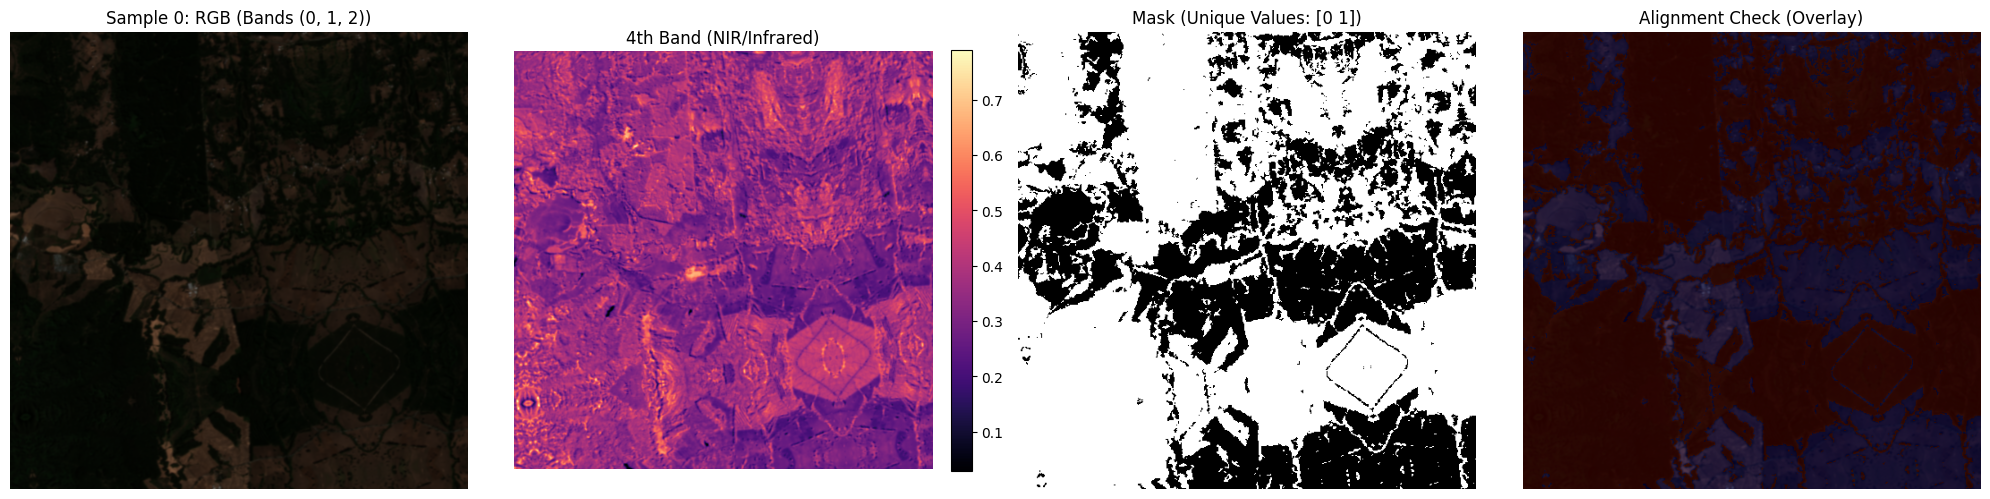

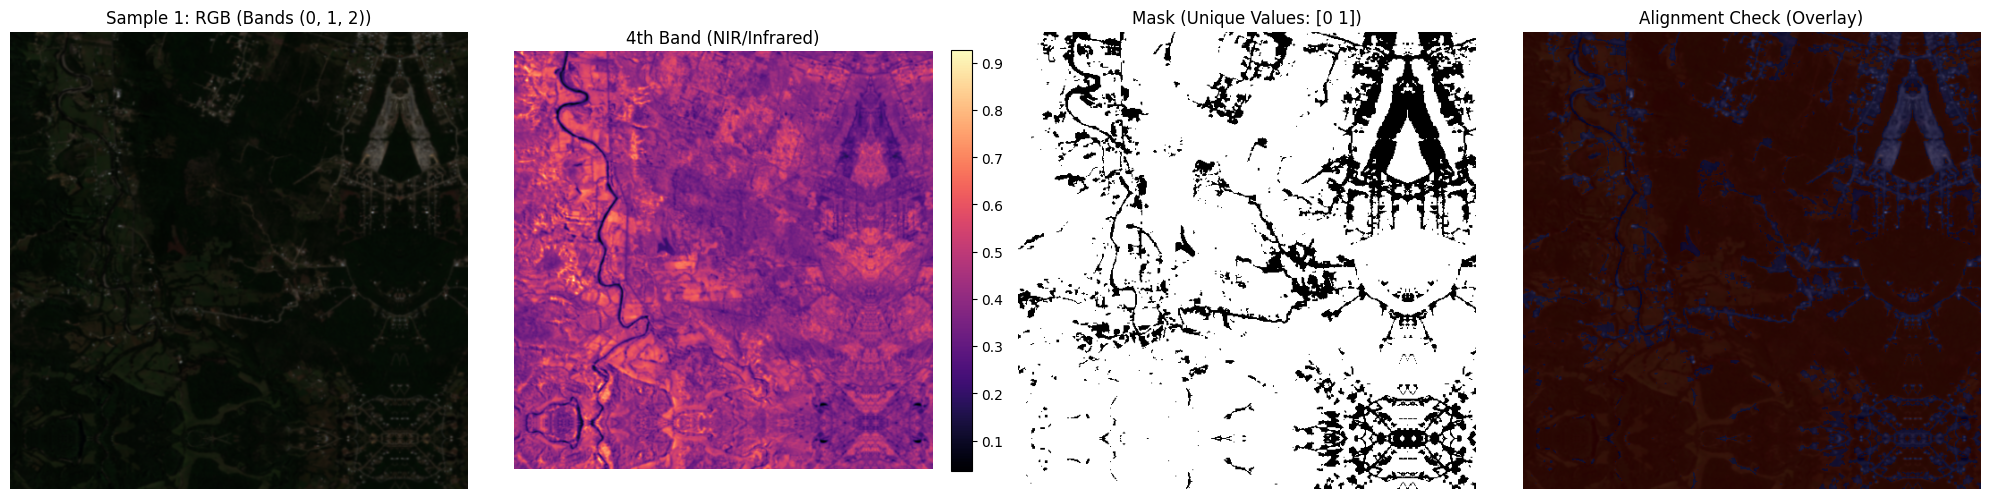

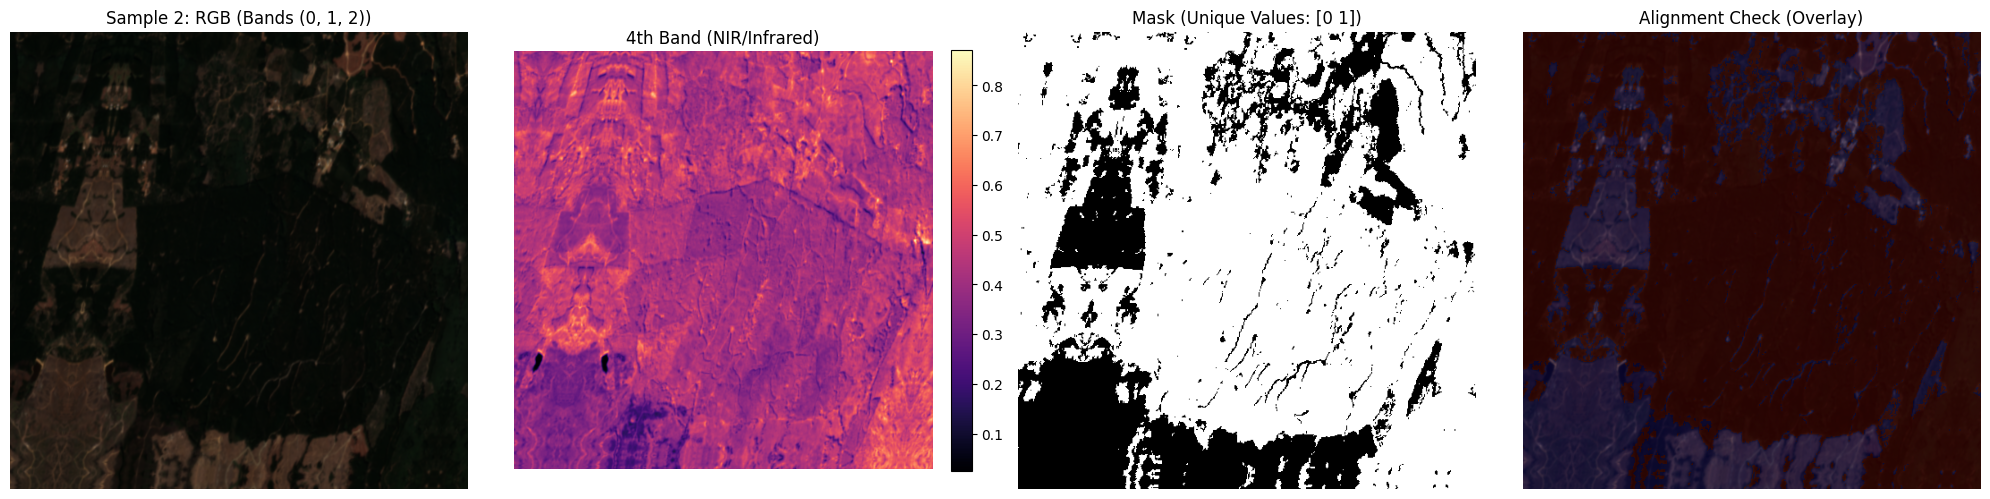


VISUALIZING VALIDATION DATA (Should be standard):
--- Visualizing 2 Samples from 4-Band Dataset ---


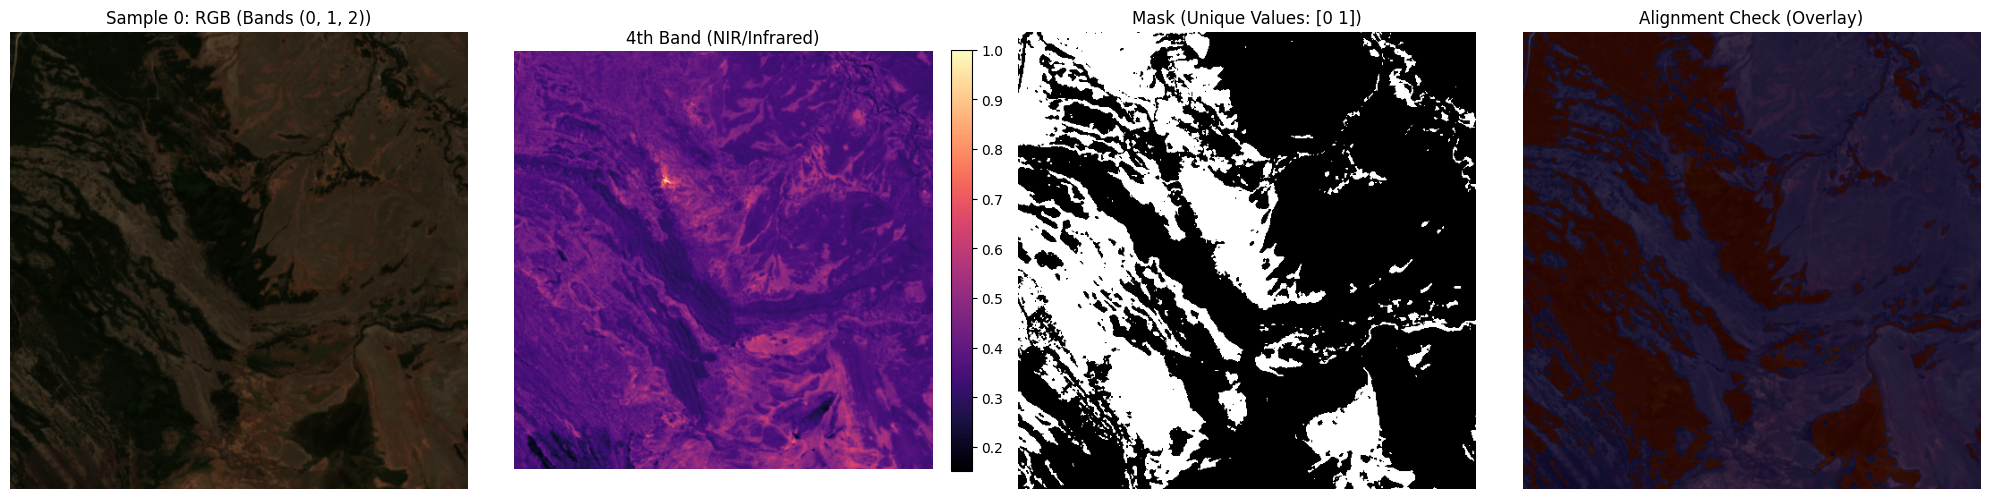

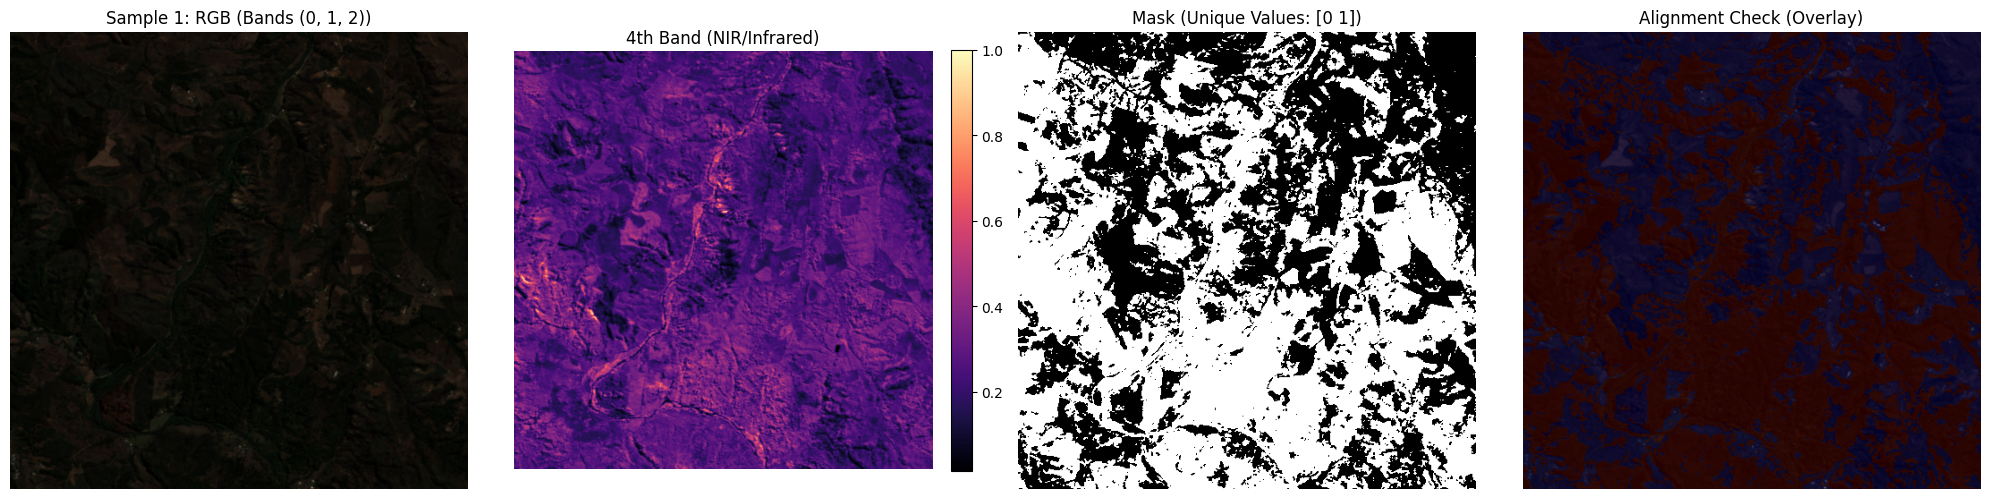

In [6]:

def visualize_4band_dataset(dataset, num_samples=3, band_order=(0, 1, 2)):
    """
    Visualizes 4-band imagery by splitting it into RGB and the 4th Band (NIR).
    
    Args:
        dataset: Your PyTorch dataset (FourBandAmazonDataset)
        num_samples: How many images to show
        band_order: Indices of (Red, Green, Blue) bands. 
                    Default (0,1,2) assumes the Tiff is saved as R-G-B-NIR.
    """
    
    # Create a small loader to get a batch
    # We use batch_size=1 just to grab samples easily
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    
    print(f"--- Visualizing {num_samples} Samples from 4-Band Dataset ---")
    
    for i, (image, mask) in enumerate(loader):
        if i >= num_samples:
            break
            
        # 1. Unpack Tensor: (1, 4, H, W) -> (4, H, W)
        img_tensor = image.squeeze(0)
        mask_tensor = mask.squeeze(0)
        
        # 2. Extract RGB Channels for display
        # We assume the image is already normalized 0-1 by your Dataset class
        r_band = img_tensor[band_order[0], :, :].numpy()
        g_band = img_tensor[band_order[1], :, :].numpy()
        b_band = img_tensor[band_order[2], :, :].numpy()
        
        # Stack them to create a standard RGB image for Matplotlib
        rgb_img = np.stack([r_band, g_band, b_band], axis=-1)
        
        # 3. Extract the 4th Band (Usually NIR - Near Infrared)
        # We assume it is at index 3 (the last one)
        nir_band = img_tensor[3, :, :].numpy()
        
        # 4. Process Mask (Remove extra dims)
        mask_img = mask_tensor.squeeze().numpy()

        # --- PLOTTING ---
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        
        # A. RGB Composition
        ax[0].imshow(rgb_img)
        ax[0].set_title(f"Sample {i}: RGB (Bands {band_order})")
        ax[0].axis('off')
        
        # B. 4th Band (Heatmap style)
        # We use a colormap to see the signal intensity clearly
        im_nir = ax[1].imshow(nir_band, cmap='magma')
        ax[1].set_title("4th Band (NIR/Infrared)")
        ax[1].axis('off')
        plt.colorbar(im_nir, ax=ax[1], fraction=0.046, pad=0.04)
        
        # C. Ground Truth Mask
        ax[2].imshow(mask_img, cmap='gray')
        ax[2].set_title(f"Mask (Unique Values: {np.unique(mask_img)})")
        ax[2].axis('off')
        
        # D. Overlay (Check Alignment)
        # We plot the mask ON TOP of the RGB image with transparency (alpha)
        ax[3].imshow(rgb_img)
        ax[3].imshow(mask_img, cmap='jet', alpha=0.3) # 30% transparent mask
        ax[3].set_title("Alignment Check (Overlay)")
        ax[3].axis('off')
        
        plt.tight_layout()
        plt.show()

# --- RUN IT ---
# Try checking both Training (Augmented) and Validation (Raw)
print("VISUALIZING TRAINING DATA (Should show rotation/flips/reflection):")
visualize_4band_dataset(train_ds, num_samples=3)

print("\nVISUALIZING VALIDATION DATA (Should be standard):")
visualize_4band_dataset(val_ds, num_samples=2)

## Training



In [ ]:
# Training Configuration

# Create directories for saving models and figures
os.makedirs('models_pytorch', exist_ok=True)
os.makedirs('figures_pytorch', exist_ok=True)
os.makedirs('metrics_pytorch', exist_ok=True)

# Loss function
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

print("Setup complete. Ready for training.")

In [ ]:
# Attention U-Net on RGB (3-channel)

print("Training Attention U-Net on RGB data...\n")

model_attn_unet_4band = AttentionUNet(in_channels=4, out_channels=1, filter_base=16).to(device)
optimizer_attn_unet_4band = torch.optim.Adam(model_attn_unet_4band.parameters(), lr=0.0005,
                                           betas=(0.9, 0.999), eps=1e-7)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_attn_unet_4band, mode='min', factor=0.1, patience=5, verbose=True
# )                                           

history_attn_unet_4band = train_model(
    model_attn_unet_4band,
    train_loader_4band,
    val_loader_4band,
    criterion,
    optimizer_attn_unet_4band,
    num_epochs=60,
    steps_per_epoch=100,
    device=device,
    save_path='models_pytorch/attention-unet-4d.pth',
    verbose=1
)

# Save history
np.save('models_pytorch/attention-unet-4d-history.npy', history_attn_unet_4band)

# Plot training curves
plot_training_history(history_attn_unet_4band,
                     save_path='figures_pytorch/attention-unet-4d-history.png')

## pp

## pp

## pp   


## pp   
